In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#new
from sklearn.model_selection import train_test_split


Wczytanie danych

In [2]:
#sciezka
data=pd.read_csv(r'C:\\Python education\\WADProjects\\Proj1\\dataKobe.csv')

Zobaczmy atrybuty i ich typy:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
action_type           30697 non-null object
combined_shot_type    30697 non-null object
game_event_id         30697 non-null int64
game_id               30697 non-null int64
lat                   30697 non-null float64
loc_x                 30697 non-null int64
loc_y                 30697 non-null int64
lon                   30697 non-null float64
minutes_remaining     30697 non-null int64
period                30697 non-null int64
playoffs              30697 non-null int64
season                30697 non-null object
seconds_remaining     30697 non-null int64
shot_distance         30697 non-null int64
shot_made_flag        25697 non-null float64
shot_type             30697 non-null object
shot_zone_area        30697 non-null object
shot_zone_basic       30697 non-null object
shot_zone_range       30697 non-null object
team_id               30697 non-null int64
team_name         

Weźmy pod uwagę analityczne znaczenie poszczególnych atrybutów, patrząc na liczbę przyjmowanych przez nie wartości.

In [4]:
atry =[wart for wart in data if data[wart].dtype=='object']
for wart in atry:
    print("")
    print(data[wart].value_counts())


Jump Shot                             18880
Layup Shot                             2567
Driving Layup Shot                     1978
Turnaround Jump Shot                   1057
Fadeaway Jump Shot                     1048
Running Jump Shot                       926
Pullup Jump shot                        476
Turnaround Fadeaway shot                439
Slam Dunk Shot                          411
Reverse Layup Shot                      395
Jump Bank Shot                          333
Driving Dunk Shot                       310
Dunk Shot                               262
Tip Shot                                182
Alley Oop Dunk Shot                     122
Step Back Jump shot                     118
Floating Jump shot                      114
Driving Reverse Layup Shot               97
Hook Shot                                84
Driving Finger Roll Shot                 82
Alley Oop Layup shot                     80
Reverse Dunk Shot                        75
Running Layup Shot             

Widzimy, że atrybuty 'team_id' i 'team_name' przyjmują po jednej wartości (odpowiednio: '1610612747' i 'Los Angeles Lakers'). Są zatem nieistotne w dalszej analizie. Usuwamy je zatem.

In [5]:
data=data.drop(['team_id','team_name'], axis=1) #axis=1 oznacza usunięcie całych kolumn

Z przeglądu danych zauważyć można, że atrybut 'matchup' w zależności od występowania separatora 'vs' albo '@' określa, czy mecz był grany odpowiednio: "u siebie" ('home'), bądź "na wyjeździe" ('away'). Jako, że mamy już informację dotyczącą przeciwnika ('opponent'), możemy usunąć kolumnę 'matchup' i stworzyć nową - 'home', która będzie zawierać infromacje dotyczące miejsca rozegrania meczu (jak wyżej).

In [6]:
data['home']=data['matchup'].apply(lambda x: 1 if 'vs' in x else 0) #1 dla 'home', 0 dla 'away'
data=data.drop('matchup',axis=1)

Weźmy pod uwagę dwie pary atrybutów określających położenie w momencie oddania strzału - loc_x i loc_y oraz lon i lat. Przedstawmy je na wykresach (dla poprawy przejrzystości w drugim wykresie odwróciliśmy kolejność osi y)

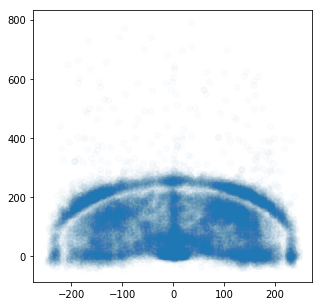

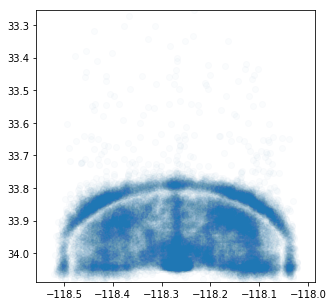

In [7]:
#plt.subplot()
plt.figure(figsize=(5,5))
plt.scatter(x=data['loc_x'],y=data['loc_y'],alpha=0.02)

plt.figure(figsize=(5,5))
plt.ylim(max(data['lat']), min(data['lat'])) #odwrócenie kolejności wartości na osi y
plt.scatter(x=data['lon'],y=data['lat'],alpha=.02)

Widzimy, że wartości są bardzo silnie skorelowane. Para loc_x i loc_y jest pewną wewnętrzną notacją, a lon i lat określa dokładne położenie geograficzne (boisko Lakersów). Co ciekawe, nawet dla meczów wyjazdowych położenie geograficzne jest przeskalowane dla wartości odpowiadających rodzimemu boisku). Ze względu na niejasności związane z tym skalowaniem, usuńmy lon i lat, zostawiając w jednakowym stopniu istotne loc_x i loc_y. W ten sposób unikamy korzystania z silnie odpowiadających sobie danych.

In [8]:
data=data.drop(['lon','lat'],axis=1)

Zauważmy również, że atrybuty 'minutes_remaining' (minuty do końca kwarty (uwaga!: kwarty w NBA mają 12 min, a nie 10, jak w Polsce)) oraz 'seconds_remaining' (wartości 0-59) logicznie jest połączyć, tworząc jeden atrybut 'time_remaining_seconds' wyrażony w sekundach.

In [9]:
data['time_remaining_seconds']=data['minutes_remaining']*60+data['seconds_remaining']
data=data.drop(['minutes_remaining','seconds_remaining'],axis=1)

Zauważmy, że Koby w najgorzej radzi sobie w ostatnich sekundach kazdej z kwart, ale chętnie podejmuje próby takich rzutów. Sensownym wydaje się utworzenie flagera określającego, czy rzut wykonany został w ostatnich 3 sekundach kwarty.

In [10]:
print("Ogólna średnia Kobiego: ",np.mean(data["shot_made_flag"]))

tabela = pd.pivot_table(data,index=["time_remaining_seconds"],values=["shot_made_flag"],aggfunc=[np.mean, len])
tabela.query('time_remaining_seconds == ["0","1","2","3","4","5","6","7","8","9","10"]')

Ogólna średnia Kobiego:  0.44616103047048294


,mean,len
,shot_made_flag,shot_made_flag
time_remaining_seconds,,
0,0.180365,520.0
1,0.275281,212.0
2,0.250000,131.0
3,0.345679,99.0
4,0.555556,85.0
5,0.409836,70.0
6,0.437500,56.0
7,0.367347,53.0


In [11]:
data['last_3_seconds']=data.time_remaining_seconds.apply(lambda x: 1 if x<=3 else 0)

Kolejnym atrybutami bez znaczenia w klasyfikacji będą wszystkie id - 'game_id','game_event_id','shot_id'. Usuwamy je zatem.

In [12]:
data=data.drop(['game_id','game_event_id','shot_id'],axis=1)

Atrybut 'season' pozwala razem z miesiącem z atrybutu 'game_date', jednoznacznie wyznaczyć rok rozgrywki. Stwórzmy atrybut 'game_month', usuwając jednocześnie 'game_date' (dokładna data wydaje się być zbędna).

In [13]:
data['game_date']=pd.to_datetime(data['game_date'])
data['game_month']=data['game_date'].dt.month
data=data.drop('game_date',axis=1)

Zajmijmy się teraz grupowaniem danych w celu stwierdzenia na podstawie posiadanych danych, typ rzutu do kosza. Ponieważ wymiary mogą być ze sobą skolerowane, dlatego pierwszym etapem naszego grupowania jest redukcja wymiarów. Wśród naszych danych występują zarówno zmienne kategoryczne jak i ilościowe, dlatego skorzystamy z metody <b>FAMD (factor analysis of mixed data)</b>, która pozwala na analizę obydwu typów danych. W pythonie pakietem, który pozwala na użycie metody FAMD jest pakiet "prince". Pakiet ten korzysta z rozkładu <b>SVD (Singular Value Decomposition)</b>, który jest bardzo szybkim sposobem redukcji wymiarów. Parametry FAMD:

*n_components-liczba wymiarów, do której chcemy zredukować zestaw danych

*n_iter-SVD jest metodą iteracyjną, dlatego n_iter jest parametrem, który kontroluje liczbę iteracji. Z jednej strony im wyższy n_iter, tym dokładniejsze będą wyniki. Z drugiej strony zwiększenie n_iter zwiększa czas obliczeń. Zasadniczo algorytm zbiega się bardzo szybko, dlatego zalecane jest użycie niskiego n_iter.

*copy-parametr mówiący o nadpisywaniu danych. Domyślnie występuje True. Jeśli wybierzemy False przekazane dane będą nadpisywane, przez co dopasowanie fit.transform() może nie działać poprawnie.

*engine-metoda z jakiej powinien korzystać SVD ('auto', 'fbpca', 'sklearn')

*random_state- jest to parametr, który kontroluje losowość wyników SVD

Na czym polega w ogóle metoda FAMD?

Załóżmy, że dane zawierają $K$ zmiennych ilościowych oraz $Q$ zmiennych jakościowych oraz $k=1,...,K$, $q=1,...,Q$. Niech $z$ będzie zmienną ilościową. Wówczas: 

$\rho{(z,k)}$ - współczynnik korelacji między zmiennymi $z,k$

$\eta^2{(z,q)}$ - współczynnik korelacji między zmiennymi $z,q$ do kwadratu

W PCA szukamy funkcji $I$, dla której

$\sum_{q}{\rho^2{(z,k)}}$ posiada maksimum

W MCA szukamy funkcji $I$, dla której

$\sum_{k}{\eta^2{(z,q)}}$ posiada maksimum

Natomiast w FAMD szukamy funkcji $I$, dla której

$\sum_{q}{\rho^2{(z,k)}}+\sum_{k}{\eta^2{(z,q)}}$ posiada maksimum



Zgodnie z powyzszymi informacjami ustalamy parametry reduckji wymiaru za pomoca FAMD:

In [14]:
import prince

famd = prince.FAMD(
     n_components=10,
     n_iter=10,
     copy=True,
     check_input=True,
     engine='auto',
     random_state=42
)

Tworzymy więc dodatkowe kolumny, tak by móc zapisać dana kategorie w postaci wektora zer i jedynek(dummy variables). Zastąpienie danych poprzez kolejne liczby naturalne mogłoby wprowadzić w błąd poprzez traktowanie tych wartości jako numeryczne.

In [15]:
dane2=data #kopia danych do dalszych obliczen
zmienne_kategoryczne=['action_type','combined_shot_type','season','opponent','shot_type','period','shot_zone_basic','shot_zone_area','shot_zone_range']
for var in zmienne_kategoryczne:
        data=pd.concat([data,pd.get_dummies(data[var],prefix=var)], 1)
        data=data.drop(var,1)


Przypomnijmy, ze zbior danych zawieral dane juz sklasyfikowane i te bez klasyfikacji. Wybierzmy z nich te wiersze, dla ktorych klasyfikacja jest przypisana, po to, by moc nastepnie je porownac z wynikiem grupowania.

In [16]:
index = dane2[pd.notna(dane2['shot_made_flag'])].index.tolist()

In [17]:
print(len(index))

25697


W zwiazku z tym, ze naszym celem jest zgrupowanie danych, usuwamy kolumne, ktora okresla klasyfikacje, tj. czy rzut zostal trafiony, czy tez spudlowany.

In [18]:
dane3 = dane2.drop('shot_made_flag', axis=1)

Ponizej umieszczamy nasze dane:

In [19]:
famd = famd.fit(dane3)  

Podejrzyjmy, jaka czesc wariancji wyjasniony zostal dla naszych danych dla kazdego z wymiarow:

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 7 Text xticklabel objects>)

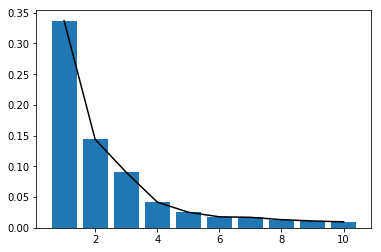

In [20]:
import matplotlib.pyplot as plt
wariancja = famd.explained_inertia_
wariancja
wymiary = np.array([1,2,3,4,5,6,7,8,9,10])



plt.bar(np.array([1,2,3,4,5,6,7,8,9,10]),wariancja)
plt.plot(wymiary,wariancja,"black")
#plt.annotate(wariancja, (wymiary, wariancja))

plt.xticks()

Widzimy, ze poczawszy od 4. wymiaru obserwujemy brak przyrostu wariancji wyjasnionej dla kazdego kolejnego dodania wymiaru do naszych zredukowanych danych.

In [21]:
suma_wariancja = np.cumsum(wariancja)
suma_wariancja


array([0.3369671 , 0.48087119, 0.57121675, 0.61304253, 0.63832524,
       0.65620167, 0.67324052, 0.68651606, 0.69762038, 0.70732304])

Widzimy zatem, ze wyjasniona wariancja dla 4 wymiarow wynosi 61%, co nie jest niestety obiecujaca wartoscia i swiadczy o nie tak duzej korelacji pomiedzy zmiennymi. Spojrzmy zatem, jak wyglada wykres korelacji naszych zmiennych pomiedzy wymiarami. W tym celu sprawdzmy, jakie sa wartosci korelacji dla poszczegolnych atrybutow i odpowiednich nowych wymiarow.

In [22]:
import math
korel = famd.column_correlations(dane3)
korel_punkty = np.array(list(zip(korel[0], korel[1]))) # tworzymy punkty dla dwoch wymiarow
korel

,0,1,2,3,4,5,6,7,8,9
action_type_Alley Oop Dunk Shot,-0.091814,0.086603,0.010234,-0.006677,-0.005820,0.003094,-0.002875,0.001048,0.209083,0.052262
action_type_Alley Oop Layup shot,-0.067144,0.080532,0.013508,-0.019359,0.028350,0.000464,0.000694,-0.015826,-0.000378,0.013360
action_type_Cutting Finger Roll Layup Shot,-0.007653,0.008945,0.001331,-0.002201,0.003195,0.000610,0.000847,-0.000160,0.000421,0.001468
action_type_Cutting Layup Shot,-0.019260,0.021783,0.004012,-0.005232,0.008372,-0.000307,-0.000244,-0.000793,0.000008,0.001366
action_type_Driving Bank shot,-0.019285,0.014402,0.001466,0.007241,-0.011755,0.001077,0.000013,0.006985,0.006728,0.001277
action_type_Driving Dunk Shot,-0.147301,0.139221,0.017301,-0.011379,-0.008699,0.006282,-0.004297,0.004771,0.359603,0.081785
action_type_Driving Finger Roll Layup Shot,-0.062620,0.074443,0.013759,-0.017418,0.027192,0.000463,0.001270,-0.001441,-0.005798,-0.013083
action_type_Driving Finger Roll Shot,-0.068028,0.080010,0.013892,-0.014622,0.021766,0.001107,0.000133,-0.019154,-0.005359,0.040249
action_type_Driving Floating Bank Jump Shot,-0.000621,-0.001446,-0.006240,0.005682,0.008161,0.002713,0.010876,0.005855,0.003114,0.000076
action_type_Driving Floating Jump Shot,-0.003971,0.005077,-0.004265,0.017827,-0.007298,-0.002697,-0.008011,0.017493,-0.001634,0.006023


W celu wizualizacji problemu mozemy teraz narysowac wykres korelacji pomiedzy zmiennymi i dwoma glownymi wymiarami, dokonujac przy tym skalowania przez sqrt(2), tak by dlugosc wektora wynosila maksymalnie 1.

Text(0, 0.5, 'Wymiar 1')

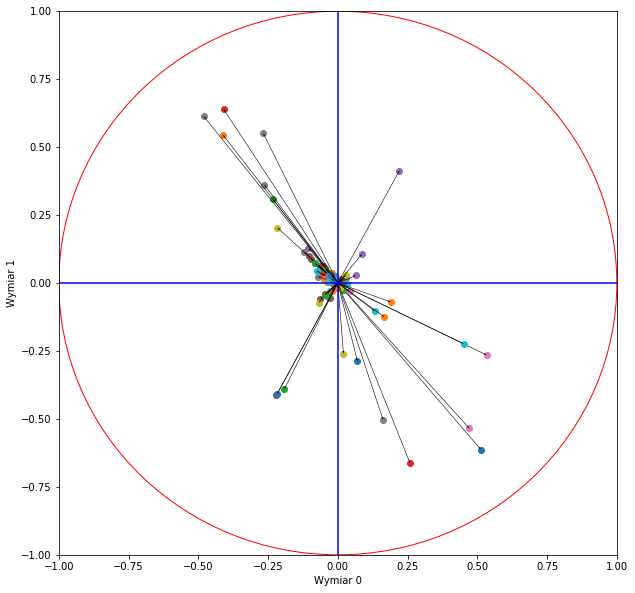

In [23]:
import matplotlib.pyplot as plt
#skalowanie 
korel_punkty = korel/math.sqrt(2)
circle1 = plt.Circle((0, 0), 1, color='r', fill = False)
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.add_artist(circle1)
x1 = [0,1]
x2 = [0,-1]
y1 = [-1,0]
y2 = [1,0]
origin = [0],[0]
ax.plot([0,0],[-1,1],"b-")
ax.plot([-1,1],[0,0],"b-")

for i in range(0,len(korel_punkty[0])):
    
    ax.scatter(korel_punkty[0][i],korel_punkty[1][i])
    ax.quiver(*origin, korel_punkty[0][i],korel_punkty[1][i],angles='xy', scale_units='xy', scale=1,width= 0.001)

ax.set_xlabel("Wymiar 0")
ax.set_ylabel("Wymiar 1")

W zwiazku z tym, ze mamy wiele atrybutow i wiele z nich jest nieskorelowanych, o czym swiadczy skupisko wektorow wokol srodka ukladu, wyeliminujemy je i zobaczymy, ktore atrybuty maja najwiekszy udzial dla tych dwoch wymiarow (wybierzmy te wektory, ktorych dlugosc wynosi co najmniej 0.5).

Text(0, 0.5, 'Wymiar 1')

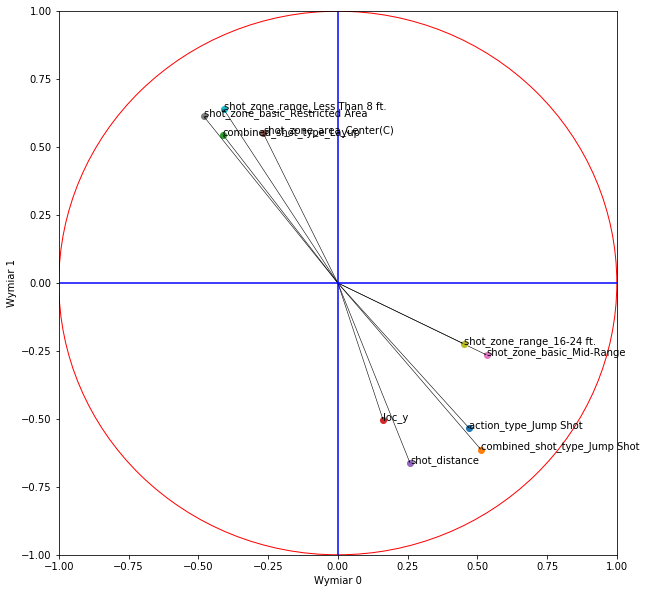

In [24]:
import matplotlib.pyplot as plt

circle1 = plt.Circle((0, 0), 1, color='r', fill = False)
fig, ax = plt.subplots() # note we must use plt.subplots, not plt.subplot
fig.set_figheight(10)
fig.set_figwidth(10)
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.add_artist(circle1)
x1 = [0,1]
x2 = [0,-1]
y1 = [-1,0]
y2 = [1,0]
origin = [0],[0]
ax.plot([0,0],[-1,1],"b-")
ax.plot([-1,1],[0,0],"b-")

for i in range(0,len(korel_punkty[0])):
    if math.sqrt(math.pow(korel_punkty[0][i],2) + math.pow(korel_punkty[1][i],2))>0.5:
        ax.scatter(korel_punkty[0][i],korel_punkty[1][i])
        ax.quiver(*origin, korel_punkty[0][i],korel_punkty[1][i],angles='xy', scale_units='xy', scale=1,width= 0.001)
        ax.annotate(korel_punkty.index[i], (korel_punkty[0][i], korel_punkty[1][i]))
ax.set_xlabel("Wymiar 0")
ax.set_ylabel("Wymiar 1")





Na podstawie wykresu korelacji mozna czesto okreslic, jak dane atrybuty maja wplyw na nasze wymiary. Im blizej osi OX znajduja sie atrybuty o duzym skorelowaniu (dodatnim badz ujemnym), tym wiekszy wplyw maja one na "Wymiar 1". Analogicznie dla "Wymiaru 0" - im blizej osi OY znajduja sie wysoko skorelowane atrybuty, tym wiekszy maja udzial.  
Na wykresie widac, ze nie ma jednoznacznie wyznaczonych atrybutow, ktore maja najwiekszy wplyw dla tych dwoch wymiarow. Mozna jedynie zobaczyc, ze na "Wymiar 0" wplyw maja glownie atrybuty "loc_y" i "shot_distance" oraz "shot_zone_range_16-24 ft." i "shot_zone_basic_Mid-Range" (oba atrybuty sa mocno ze soba skorelowane). Pozostale mocno skorelowane atrybuty leza jednak po przekatnej wykresu, co oznacza, ze odgrywaja role zarowno dla "Wymiaru 0" i "Wymiaru 1".
Oprocz tego, dzieki wykresowi korelacji mozemy okreslic pewne zaleznosci dla wymiarow. Jezeli wartosc dla "Wymiaru 0" bedzie wysoka, oznacza to, ze rzut ten najprowpodobniej nalezal do kategorii "shot_zone_range_16-24ft", "shot_zone_basic_Mid-Range", "action_type_Jump", z dalszej odleglosci, o dalszej pozycji loc_y. Mozemy wiec wnioskowac, ze jesli wartosci sa wysokie, to rzut byl z wiekszej odlegosci i z wyskoku. Jednoczesnie widzimy, ze rzuty z krotszych dystansow sa przeciwnie skorelowane dla tego wymiaru (znajduja sie po lewej stronie wykresu), wiec im mniejsze wartosci, tym z wiekszym prawdopodobienstwem mozemy uznac, ze rzut byl z bliska (nalezy pamietac, ze wartosci te byly typu binarnego (0-1, nie-tak).

Narysujmy zatem dwa glowne wymiary oraz punkty na nie naniesione.

In [25]:
x = famd.row_coordinates(dane3)

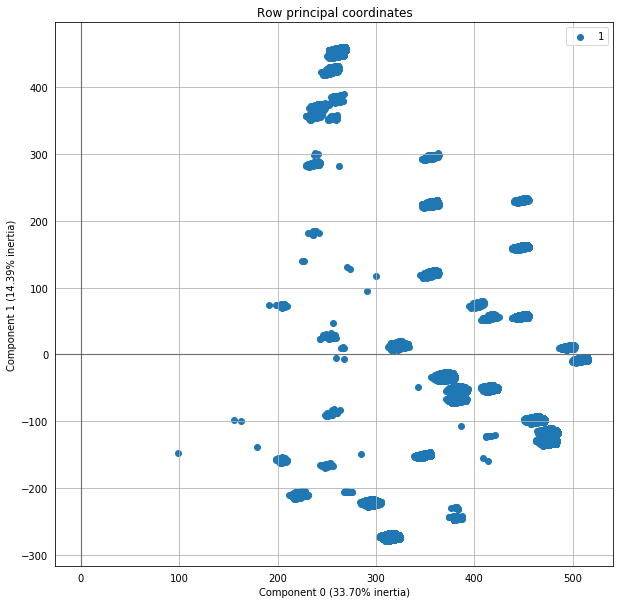

In [26]:
ax = famd.plot_row_coordinates(
     dane3,
     ax=None,
     figsize=(10, 10),
     x_component=0,
     y_component=1,
     #labels=dane3.index,
     #color_labels=['shot_made_flag {}'.format(t) for t in dane3['shot_made_flag']],
     ellipse_outline=False,
     ellipse_fill=True,
     show_points=True
)

Widzimy, ze srodek ciezkosci wykresu przesuniety jest w kierunku prawego, dolnego naroznika. Zgodnie z poprzednia analiza wykresu korelacji, mozemy wywnioskowac zatem, ze przewazaly rzuty z blizszego dystansu(ujemna korelacja dla "Wymiaru 0" z dalekiego dystansu i jednoczesnie dodatnia korelacja dla "Wymiaru 1" z krotkiego dystansu. Mozemy zatem spodziewac sie, ze kategoryzacja rzutow nastapi glownie w zwiazku z tymi atrybutami.

In [27]:
x.head()

,0,1,2,3,4,5,6,7,8,9
0,480.564100,-114.888451,-193.532371,-100.547158,15.152735,25.760731,-162.967986,-66.105049,32.471273,-7.620206
1,462.791985,-94.107238,-167.236274,128.724343,131.703527,-11.200368,191.960482,-111.956275,33.530341,-4.822699
2,475.593641,-125.838600,-140.568436,-165.521655,-64.235436,179.427445,12.116353,-5.016197,-30.069523,6.220691
3,479.717633,-129.688301,-141.806215,-183.620914,-82.930418,-147.990048,2.201919,-13.437709,-15.200693,1.000385
4,244.628732,372.841527,78.667774,-26.957836,-24.631047,5.472380,-3.534723,6.467096,258.640047,39.284669


Do grupowania danych uzyjemy metody k-srednich. W zwiazku z tym, ze nasze pierwotne dane posiadaly 2 klasy, chcemy pogrupowac te dane na 2 grupy.

W zwiazku z duzym rozrzutem naszych danych pozbedziemy sie punktow odstajacych, ktore znacznie wplywaja na przeniesienie srodka ciezkosci (usrednionych cech przedstawiciela) danej grupy. W tym celu zastosujemy metode <b>Z-Score</b>, ktora polega na znormalizowaniu kazdego z atrybutu z osobna (tj. odjecie sredniej i podzielenie przez odchylenie standardowe) dla kazdego z rzutu. Nastepnie okreslamy poziom, dla ktorego uznajemy, ze punkt wplywa na algorytm K-srednich. Dla nas jest to wartosc 1.8




In [28]:
from scipy import stats
import numpy as np
#print(x[[0,1]])
z1 = np.abs(stats.zscore(x[0]))
z2 = np.abs(stats.zscore(x[1]))
print(z1)
print(z2)
threshold =1.8
print(np.where(z1 > threshold))
outlajersy = np.where(z1 > threshold )[0]
print(len(outlajersy))
outlajers2 = np.where(z2 > threshold)[0]
print(len(outlajers2))
outlajersy = np.concatenate((outlajersy,outlajers2),axis=0)
print(len(outlajersy))
print(outlajers2)

[1.2029529  1.0046978  1.14750542 ... 0.07024772 0.28393991 0.82017414]
[0.58269712 0.49914267 0.62672408 ... 0.36539414 0.72308986 0.52723277]
(array([ 2550,  7481, 10022, 10994, 12403, 12927, 13025, 13074, 13483,
       13696, 14421, 14861, 15132, 15854, 15872, 16811, 16951, 16976,
       17213, 17361, 17678, 18173, 18472, 18678, 20283, 20440, 20893,
       21056, 21152, 21898, 22383, 22494, 22550, 22621, 24052, 27656,
       28399, 28742, 28743, 28749, 28891, 29030, 29116, 29464, 29790,
       29801, 29934, 30026], dtype=int64),)
48
0
48
[]


Wyrzucamy punkty odstajace ze zbioru danych. Mamy ich 48. Analizowanym zbiorem beda punkt reprezentowane przez kolor pomaranczowy. Punkty niebieskie do punkty odstajace, ktore zostana doklasyfikowane po przeprwoadzeniu algorytmu k-srednich.

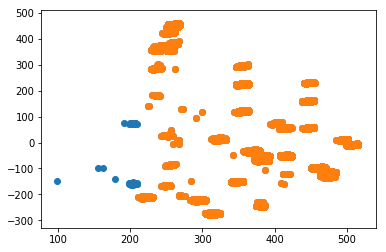

In [39]:
f1 = np.delete(np.array(x[0]), np.array(outlajersy))
f2 = np.delete(np.array(x[1]), np.array(outlajersy))

import matplotlib.pyplot as plt

plt.scatter(x[0],x[1],marker="o", cmap="bwr_r")
plt.scatter(f1,f2)


In [30]:
Xdane = np.array(list(zip(f1, f2)))

Stosujemy algorytm K-srednich dla 2 grup.

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2)
kmeans = kmeans.fit(Xdane)
labels = kmeans.predict(Xdane)
centroids = kmeans.cluster_centers_

In [32]:
print(centroids)

[[ 270.90824356  402.7611394 ]
 [ 409.76478586 -104.05132471]]


Ponizej przedstawiamy efekt grupowania. Na zielono zaznaczono, jak wyglada usredniony przedstawiciel tej grupy.

Text(413.8624337159597, -105.09183795812963, '1')

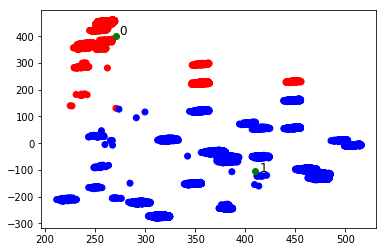

In [33]:
#%matplot inline
import matplotlib.pyplot as plt
colors = labels 
plt.scatter(f1,f2,c=colors,marker="o", cmap="bwr_r")
plt.scatter(centroids[0][0],centroids[0][1],color='green')
plt.text(centroids[0][0] * (1 + 0.01), centroids[0][1] * (1 + 0.01) , 0, fontsize=12)
plt.scatter(centroids[1][0],centroids[1][1],color='green')
plt.text( centroids[1][0]* (1 + 0.01), centroids[1][1] * (1 + 0.01) , 1, fontsize=12)

Definiujemy wyniki grupowania:

In [34]:
df = pd.DataFrame(np.array(labels))
wyniki_grupowania = df[0]


Zobaczymy teraz, jak pogrupowanie danych rozni sie z tym, czy rzut zostal trafiony, czy chybiony. Wybierzmy w tym celu te indeksy, ktorych wiersze zostaly zgrupowane.

In [36]:
zgrupowane_indeksy = list(set(np.array(index)) - set(np.array(outlajersy)))

In [37]:

suma = 0
for i in range(0, len(zgrupowane_indeksy)):
    if data['shot_made_flag'].iloc[index[i]] != wyniki_grupowania[index[i]]:
        suma += 1
#Pokryte wartosci:
print(suma/len(zgrupowane_indeksy)*100)


52.724508886810106


Jak widac, grupowanie nie ma na celu klasyfikowania rekordow dla okreslonego celu. Ma ono bowiem zupelnie inne zadanie jako proces nienadzorowany - szukane sa cechy charakterystyczne dla kazdej z grup, a nie cechy majace wplyw na okreslony rezultat. Trzeba rowniez stwierdzic, ze wyodrebnienie dwoch grup dla tego zbioru nie bylo efektywne z tego wzgledu, ze nie widzimy duzych podobienstw wewnatrz grup, a wariancja miedzy grupami na pewno nie jest na tyle niska, zeby byla zadowalajaca. Pierwotnie nalezaloby dokonac analizy wartosci wariancji wewnatrz- i miedzygrupowej i na jej podstawie wybrac odpowiednia liczbe grup dla tego zbioru.